### Setup

In [24]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Data loading and preprocessing

In [25]:
# Loading data set
df = pd.read_excel("/Users/rasmuskrebs/Documents/School/master_thesis/repo/dimension_reduction/PrincipalComponentAnalysis_results.xlsx", sheet_name="Dimension Reduction (Raw)")

### Initial preprocessing

# Forward fill to fill model names across small, medium and long
df.iloc[0,:] = df.iloc[0,:].fillna(method='ffill')

# Drop empty columns
df = df.drop(columns=["Unnamed: 1", "Unnamed: 2", "Unnamed: 3"])

# Fill missing values in measurement with Measurement
df.Measurement = df.Measurement.fillna("Measurement")

# Assign first row as columns rather than existing
df.columns = df.iloc[0,:].values

# Drop first row
df = df.iloc[1:,:]

# Reset index and transpose
df = df.set_index("Measurement").T

# Strip trailing and leading white spaces and replace double spaces with single
df.columns = [col.strip().replace("  ", " ") for col in df.columns]


df.head()

,Metric,Lines of Code,Source Lines of Code,Single Line Comments,Multiline Comments,Blank lines,Single comments-to-lines,Single comments-to-source lines,comments-to-lines,Pylint Rating,...,Halstead Effort,Halstead Time to Write,Halstead Bugs,Cyclomatic Complexity,Maintainability Index,Cyclomatic Complexity / Methods,Methods,SLOC/Methods,Total Memory Usage (MiB),CPU Usage Per Cent
Baseline,NaN,139,53,14,44,28,0.11,0.28,0.42,9.79,...,1498.39,83.24,0.09,6,66.4,1.5,4,13.25,161.9,22.1
GPT 3.5,Small,42,19,10,0,13,0.24,0.53,0.24,2.63,...,22.46,1.25,0.007,1,89.87,0.5,2,9.5,131,22.35
GPT 3.5,Medium,136,37,7,64,28,0.05,0.19,0.52,7.78,...,697.03,38.72,0.055,3,55.04,0.75,4,9.25,89.3,22.39
GPT 3.5,Long,139,51,20,41,28,0.14,0.39,0.43,5.12,...,734.275614,40.79,0.043,6,67.1,1.5,4,12.75,152.4,22.78
GPT 4,Small,28,21,8,0,3,0.29,0.47,0.29,0,...,36,2,0.008,1,88.89,0.333333,3,7,815.3,20.042


In [26]:
### Preprocessing: Goal is to transform the data into a format, such that the various range don't influence the final score. Therefore, all values will be transformed into a 0-1 range. Min-max scaling is used for continuous variables, and in those obivous 
# cases, where the data is already on a finite scale, e.g. 0-100, the data is not scaled, but rather normalized.

# Copying data frame, such that the original is not changed
df0 = df.copy()

### Normalizing aggregate counts, such that the different lenghs are comparable
df0["Errors (E)"] = df0["Errors (E)"] / df0["Lines of Code"]
df0["Errors (E)"] = df0["Errors (E)"] / max(df0["Errors (E)"])

df0["Warnings (W)"] = df0["Warnings (W)"] / df0["Lines of Code"]
df0["Warnings (W)"] = df0["Warnings (W)"] / max(df0["Warnings (W)"])

df0["Refactoring Checks (R)"] = df0["Refactoring Checks (R)"] / df0["Lines of Code"]
df0["Refactoring Checks (R)"] = df0["Refactoring Checks (R)"] / max(df0["Refactoring Checks (R)"])


df0["Style Convenetion Errors (C)"] = df0["Style Convenetion Errors (C)"] / df0["Lines of Code"]
df0["Style Convenetion Errors (C)"] = df0["Style Convenetion Errors (C)"] / max(df0["Style Convenetion Errors (C)"])

# Dividing columns on finite scale
df0['Pylint Rating'] = df0['Pylint Rating'] / 10
df0['Maintainability Index'] = df0['Maintainability Index'] / 100
df0['CPU Usage Per Cent'] = df0['CPU Usage Per Cent'] / 100


# Metrics used
reliability_metrics = ["Errors (E)", "Warnings (W)", "Cyclomatic Complexity", "Halstead Bugs"]
maintainability_metrics = ["Maintainability Index", "Refactoring Checks (R)", "Style Convenetion Errors (C)", "comments-to-lines", "SLOC/Methods"]
performance_metrics = ['Total Memory Usage (MiB)', 'CPU Usage Per Cent']
security_metrics = ["Warnings (W)", "Errors (E)", "Pylint Rating"]

# Unique metrics
metrics = list(set(reliability_metrics + maintainability_metrics + performance_metrics + security_metrics)) + ['Metric']
df0 = df0[metrics]

In [27]:
# Metrics used
reliability_metrics = ["Errors (E)", "Warnings (W)", "Cyclomatic Complexity", "Halstead Bugs"]
maintainability_metrics = ["Maintainability Index", "Refactoring Checks (R)", "Style Convenetion Errors (C)", "comments-to-lines", "SLOC/Methods"]
performance_metrics = ['Total Memory Usage (MiB)', 'CPU Usage Per Cent']
security_metrics = ["Warnings (W)", "Errors (E)", "Pylint Rating"]

# Unique metrics
metrics = list(set(reliability_metrics + maintainability_metrics + performance_metrics + security_metrics)) + ['Metric']
df0 = df0[metrics]

In [28]:
# Scaling the data
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
scaling_metrics = df0.iloc[:, :-1].columns # ['Total Memory Usage (MiB)','Halstead Bugs','Style Convenetion Errors (C)', 'Warnings (W)', 'SLOC/Methods', 'Refactoring Checks (R)', 'Cyclomatic Complexity', 'Errors (E)']

# Normalize the metrics
normalized = scaler.fit_transform(df0[scaling_metrics])
df_normalized = pd.DataFrame(normalized, columns=scaling_metrics, index=df0.index)
df_normalized['Metric'] = df0['Metric']
# df_normalized.index = df.index

# Partitioning datasets
long = df_normalized[(df_normalized.Metric == "Long") | (df_normalized.Metric.isna())]
medium = df_normalized[(df_normalized.Metric == "Medium") | (df_normalized.Metric.isna())]
small = df_normalized[(df_normalized.Metric == "Small") | (df_normalized.Metric.isna())]


### Helpers

In [29]:
# Partitioning dataframe into ISO 5055
def iso_partion(df:pd.DataFrame, metrics: list):
    return df[metrics]

In [30]:
# Generate composite score
def composite_score(df, metrics, weights, negative = False):
    
    # Initialize the MinMaxScaler
    #scaler = MinMaxScaler()
    
    # Normalize the metrics
    # df_normalized = scaler.fit_transform(df[metrics])
    # df_normalized = pd.DataFrame(df_normalized, columns=metrics)
    # df_normalized.index = df.index
    # 
    # Compute the composite score
    df['composite_score'] = df.apply(lambda x: sum(x[metric] * weight for metric, weight in weights.items()), axis=1)
    
    # If negative, then reverse the composite score
    if negative:
        df['composite_score'] = -df['composite_score']
    
    return df
    

In [31]:
# palette = sns.color_palette(['red','green','blue'])#'#182787','#4754a8', '#818bcc'])
palette = sns.color_palette(['#3F92A8','#e2c222','#E43307'])#'#182787','#4754a8', '#818bcc'])

## ISO Partioning
See notion [here](https://www.notion.so/raskrebs/ISO-5055-Metric-Groupings-aabc91707db0428f91a2ffd4296b0814?pvs=4)

In [32]:
# Model renaming
model_names = {"Codex":"Codex",
 "DeepSeeker-Coder":"DeSe-Co",
 "WizardCoder":"WiCo",
 "Tabnine":"T9",
 "GPT 4":"GPT4",
 "GPT 3.5":"GPT35",
 "Gemini/Bard":"Gemini",
 "CodeLLama":"CLLam",
 }

### Reliability

In [33]:
def relaibility(df_length, version):
    # Relability Comsposite Score
    weights = {"Errors (E)": 0.25,
               "Warnings (W)": 0.25,
               "Cyclomatic Complexity": 0.3, 
               "Halstead Bugs": 0.2}


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]
    
    # Subtracting from 1, such that the higher the score, the better
    for metric in metrics:
        df[metric] =  1 - df[metric]

    # Compute the composite score
    df = composite_score(df, 
                         metrics, 
                         weights)
    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)
    
    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version
    
    return df

In [34]:
# Transform
long_relaibility = relaibility(long, 'long')
medium_relaibility = relaibility(medium, 'medium')
small_relaibility = relaibility(small, 'small')

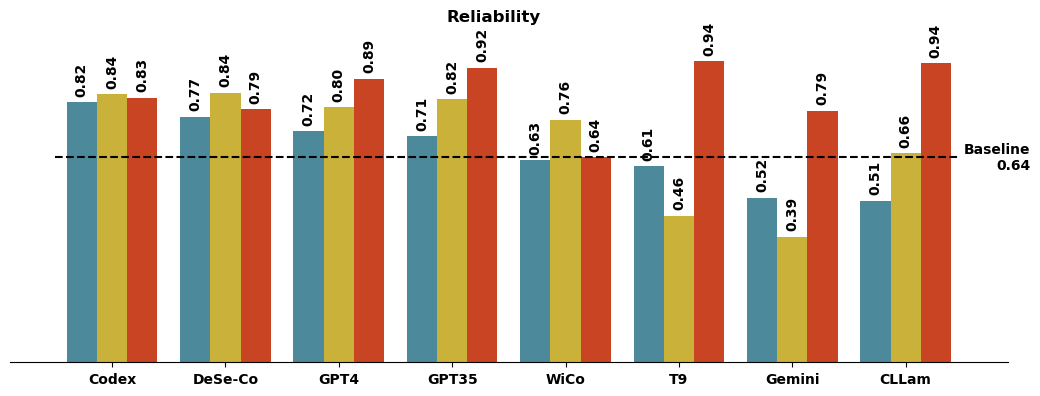

In [61]:
# Concatenating the data
concat_columns = ['model', 'version', 'composite_score']
relaibility_plot_data = pd.concat([long_relaibility[concat_columns], medium_relaibility[concat_columns], small_relaibility[concat_columns]])
relaibility_plot_data = relaibility_plot_data[relaibility_plot_data.model != 'Baseline']
relaibility_plot_data.model = relaibility_plot_data.model.map(model_names)
baseline_value = long_relaibility[long_relaibility.model == 'Baseline'].composite_score.values[0]

# Plotting
g = sns.catplot(data=relaibility_plot_data, 
                kind='bar', 
                x='model', 
                y='composite_score', 
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Reliability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(baseline_value, -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, baseline_value, f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Maintainability

In [36]:
def maintainability(df_length, version):
    # Weights for maintainability composite score
    weights = {
        'Refactoring Checks (R)': 0.25,  # Low severity
        'Style Convenetion Errors (C)': 0.15,  # Low severity
        "comments-to-lines": .2, # The higher the ratio, the better the maintainability as more documentation is provided
        "SLOC/Methods": 0.2, # High ratio indicates low maintainability as they are likely then more complex and harder to maintain 
        'Maintainability Index': 0.2  # Direct measure of maintainability, so just balanced. It's not given a higher weights since MIs between 60-100 are generally considered good
        }  


    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = df_length[metrics]

    # Maintainability specific preprocessing: Invert all scores, where closer to zero is better
    # df['Refactoring Checks (R)'] *= -1
    # df['Style Convenetion Errors (C)'] *= -1
    # df['SLOC/Methods'] *= -1
    df['Refactoring Checks (R)'] = 1 - df['Refactoring Checks (R)']
    df['Style Convenetion Errors (C)'] = 1 - df['Style Convenetion Errors (C)']
    df['SLOC/Methods'] = 1 - df['SLOC/Methods']


    # Compute the composite score
    df = composite_score(df, 
                         metrics, 
                         weights)
    
    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)
    
    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version
    
    return df

In [37]:
# Compute the composite score
maintainability_long = maintainability(long, 'long')
maintainability_medium = maintainability(medium, 'medium')
maintainability_small = maintainability(small, 'small')

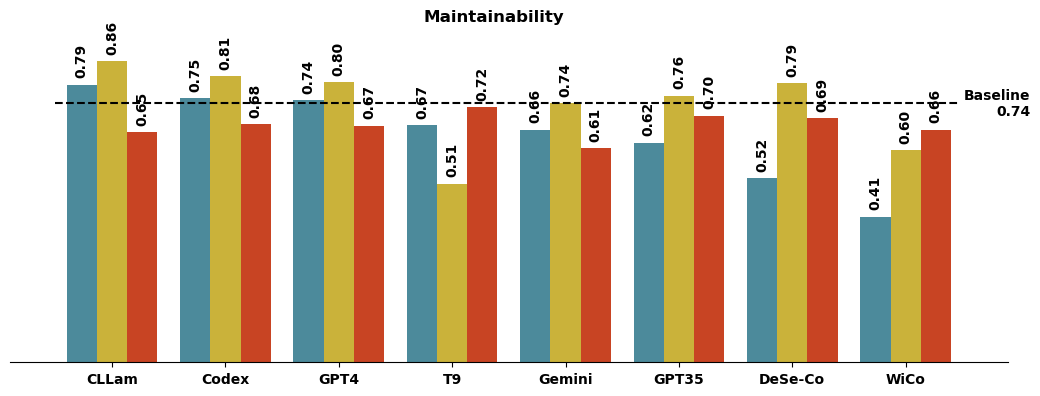

In [60]:
# Concatenating the data
maintainability_plot_data = pd.concat([maintainability_long[concat_columns], maintainability_medium[concat_columns], maintainability_small[concat_columns]])
maintainability_plot_data = maintainability_plot_data[maintainability_plot_data.model != 'Baseline']
baseline_value = maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0]
maintainability_plot_data.model = maintainability_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=maintainability_plot_data, 
                kind='bar', 
                x='model', 
                y='composite_score', 
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Maintainability', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, maintainability_long[maintainability_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Performance Efficiency

In [39]:
def performance(length, version):
    # Weights for performance composite score
    weights = {
        'Total Memory Usage (MiB)' : 0.5,
        'CPU Usage Per Cent' : 0.5}  

    metrics = weights.keys()

    assert sum(weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(weights.values()))

    # Maintainability long
    df = length[metrics]
    
    # Invert the CPU Usage Per Cent to ensure higher scores indicate better performance
    df['CPU Usage Per Cent'] = 1 - df['CPU Usage Per Cent'] 
    df['Total Memory Usage (MiB)'] = 1 - df['Total Memory Usage (MiB)'] 

    # Compute the composite score
    df = composite_score(df, 
                         metrics, 
                         weights)
    
    # Resetting index
    df['model'] = df.index
    df = df.reset_index(drop=True)
    
    # Sorting by composite score
    df = df.sort_values(by="composite_score", ascending=False)
    df['version'] = version
    
    return df

In [40]:
# Compute the composite score
performance_long = performance(long, 'long')
performance_medium = performance(medium, 'medium')
performance_small = performance(small, 'small')

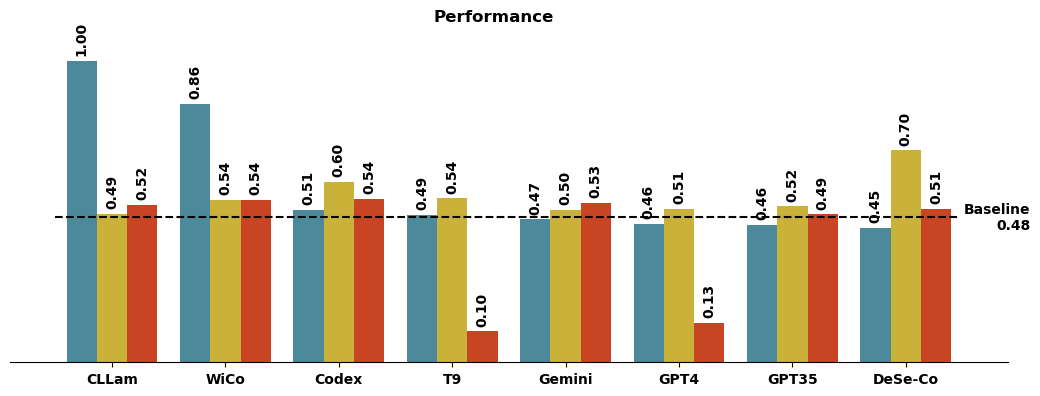

In [59]:

performance_plot_data = pd.concat([performance_long[concat_columns], performance_medium[concat_columns], performance_small[concat_columns]])
performance_plot_data = performance_plot_data[performance_plot_data.model != 'Baseline']
baseline_value = performance_long[performance_long.model == 'Baseline'].composite_score.values[0]
performance_plot_data.model = performance_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=performance_plot_data, 
                kind='bar', 
                x='model', 
                y='composite_score', 
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Performance', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(performance_long[performance_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, performance_long[performance_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
#g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')

# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()

### Security
*Static code checks can indirectly relate to security by encouraging good coding practices that can prevent certain types of vulnerabilities, but generally these are only indicative. Security is overall difficult to test for using only static code analysis*

In [42]:
def security(df_length, version):
    # Weights for security composite score.
    security_weights = {
        "Warnings (W)": .3,
        "Errors (E)": .3,
        "Pylint Rating": .4,
    }  


    # Metrics from long to include
    security_metrics = security_weights.keys()

    assert sum(security_weights.values()) == 1, "Weights must sum to 1, but sum to {}".format(sum(security_weights.values()))

    # Security long
    df = df_length[security_metrics]

    # Invert the negative scores, such that these negatively influence the rating
    df['Warnings (W)'] = 1 - df['Warnings (W)']
    df['Errors (E)'] = 1 - df['Errors (E)']


    # Compute the composite score
    df = composite_score(df, 
                                   security_metrics, 
                                   security_weights)
    
    # df['composite_score'] /= 3
    
    # Assign model to column rather than index
    df['model'] = df.index
    df = df.reset_index(drop=True)
    
    # Add version
    df['version'] = version
    
    return df

In [43]:
security_long = security(long,'long')
security_medium = security(medium,'medium')
security_small = security(small,'small')

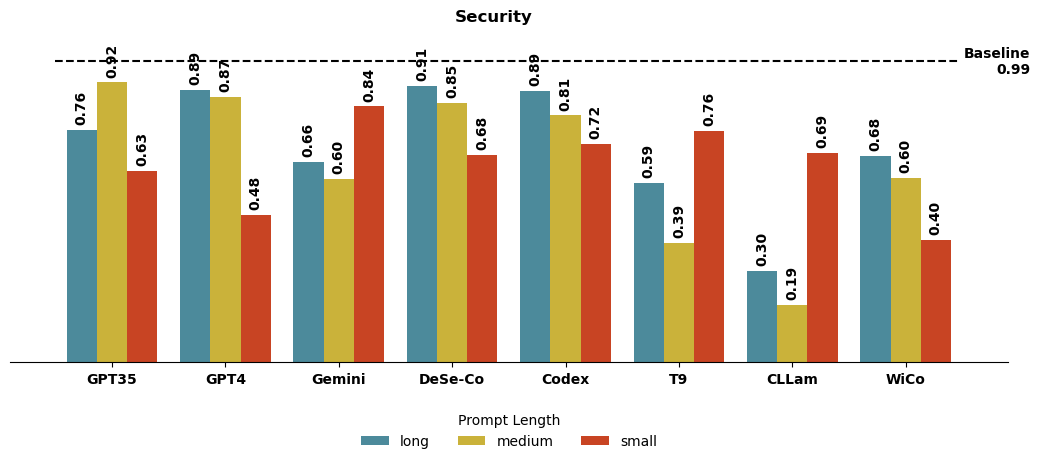

In [58]:

# fig, axs = plt.subplots(figsize=(11, 4))
security_plot_data = pd.concat([security_long[concat_columns], security_medium[concat_columns], security_small[concat_columns]])
security_plot_data = security_plot_data[security_plot_data.model != 'Baseline']
baseline_value = security_long[security_long.model == 'Baseline'].composite_score.values[0]
security_plot_data.model = security_plot_data.model.map(model_names)

# Plotting
g = sns.catplot(data=security_plot_data, 
                kind='bar', 
                x='model', 
                y='composite_score', 
                hue='version',
                palette=palette,
                legend=False
                )

# Set labels, title and size
g.set_axis_labels("", "Value")
g.figure.suptitle('Security', weight='bold')
g.figure.set_size_inches(11, 4)  # Set width to 10 inches and height to 6 inches

# Add baseline line
g.figure.axes[0].hlines(security_long[security_long.model == 'Baseline'].composite_score.values[0], -.5, 7.5, colors='black', linestyles='--')
g.figure.axes[0].text(8.1, security_long[security_long.model == 'Baseline'].composite_score.values[0], f'Baseline\n{round(baseline_value,2)}', ha='right', va='center', backgroundcolor='w', weight='bold')
g.figure.tight_layout()
g.figure.axes[0].set_ylabel('')  # Remove y-axis label
g.figure.axes[0].set_yticks([])  # Remove y-axis ticks
g.figure.legend(bbox_to_anchor=(0.66, 0), ncols=3, frameon=False, title='Prompt Length')
g.figure.axes[0].spines['left'].set_visible(False)
# Add annotations to the bars
for p in g.ax.patches:
    g.ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()+.03), ha='center', va='center', rotation=90,xytext=(0, 10), textcoords='offset points', weight='bold')
# Make x-axis ticks bold
g.ax.set_xticklabels(g.ax.get_xticklabels(), weight='bold')

plt.show()